In [1]:
import pandas as pd
import numpy as np
pd.set_option('future.no_silent_downcasting', True)

In [2]:
df_water = pd.read_excel("data/SuEatableLife_Food_Fooprint_database.xlsx", sheet_name = "SEL WF for users")
df_water = df_water.replace('-',np.nan)
df_co2 = pd.read_csv("data/Clean_CO2.csv")
df_prod = pd.read_csv("data/Production_Crops_Livestock_E_All_Data.csv")
df_common = pd.read_excel("data/common.xlsx")

C:\Users\User\AppData\Local\Temp\ipykernel_4200\1875884548.py:4: DtypeWarning: Columns (11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,110,113,116,119,122,125,128,131,134,137,140,143,146,149,152,155,158,161,164,167,170,173,176,179,182,185,188,191,194,197) have mixed types. Specify dtype option on import or set low_memory=False.
  df_prod = pd.read_csv("data/Production_Crops_Livestock_E_All_Data.csv")


In [3]:
df_water.rename(columns={ 
                       "FOOD COMMODITY GROUP" : "food_commodity_group",
                       "Food commodity ITEM" : "food_commodity_item",  
             "Food commodity TYPOLOGY" : "food_commodity_typology",
             "Food commodity sub-TYPOLOGY": "Food_commodity_sub-TYPOLOGY",
                }, inplace= True)

In [4]:
print(len(df_co2["food_commodity_item"]))
print(len(df_water["food_commodity_item"]))

324
320


In [5]:
#lower all strings
df_water = df_water.map(lambda x: x.lower() if type(x) == str else x)
df_co2 = df_co2.map(lambda x: x.lower() if type(x) == str else x)
df_prod = df_prod.map(lambda x: x.lower() if type(x) == str else x)

In [6]:
def remove_asterix(df):
    '''
    We remove * as it corresponds to typologies having only one item in it and as it is different between the 2 datasets
    '''
    df.replace(to_replace = r"\*+",value=  '',inplace = True,regex=True)
    return df
def remove_s(df):
    '''
    Removing s at the end of words to avoid bananas not matching with banana
    '''
    df.replace({r'(\w+)(s)$' : r'\1'}, inplace = True,regex=True)
    return df


In [7]:
df_water['food_commodity_item']= df_water['food_commodity_item'].str.strip()
df_co2['food_commodity_item'] = df_co2['food_commodity_item'].str.strip()
df_prod['Item'] = df_prod['Item'].str.strip()
df_co2 = remove_asterix(df_co2)
df_water = remove_asterix(df_water)
df_water['food_commodity_item'] = remove_s(df_water['food_commodity_item'])
df_co2['food_commodity_item'] = remove_s(df_co2['food_commodity_item'])
df_prod['Item'] = remove_s(df_prod['Item'])

In [8]:
#remove lines where it is imported 
def remove_parenthesis_in_item(df, content_of_parenthesis):
    '''
    At the end of certain items there are parenthesis giving information on the item e.g (i) correspond to imported.
    However the others datasets don't have the same level of information and we just keep the main item if existing.
    '''
    df_imported = df[df['food_commodity_item'].str.contains(fr"\({content_of_parenthesis}\)")]
    for idx,row in df_imported.iterrows():
        item_to_find = row["food_commodity_item"][:-4]
        if df['food_commodity_item'].str.contains(item_to_find).sum() >1:
            df = df[df["food_commodity_item"] != row["food_commodity_item"]]
        else:
            # Replace using loc instead of replace to avoid warnings
            mask = df["food_commodity_item"] == row["food_commodity_item"]
            df.loc[mask, "food_commodity_item"] = item_to_find
    return df

# We remove those detailed informations but we might create small games to learn what consumes more between greenhouse or imported for example
df_co2 = remove_parenthesis_in_item(df_co2, "g")
df_co2 = remove_parenthesis_in_item(df_co2, "i")
df_water = remove_parenthesis_in_item(df_water, "f")
df_co2 = remove_parenthesis_in_item(df_co2, "G")
df_co2 = remove_parenthesis_in_item(df_co2, "f")
df_co2 = remove_parenthesis_in_item(df_co2, "l")
df_co2

C:\Users\User\AppData\Local\Temp\ipykernel_4200\2638439649.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  if df['food_commodity_item'].str.contains(item_to_find).sum() >1:


,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY,CF_food_sub_typology
0,0,agricultural processed,beer in can,0.693000,l,ok item,beer,0.69,NaN,NaN
1,1,agricultural processed,beer in glas,0.960500,l,ok item,beer,0.69,NaN,NaN
2,2,agricultural processed,beer modular can,0.530600,l,ok item,beer,0.69,NaN,NaN
3,3,agricultural processed,chocolate or cream filled cookie,1.533000,l,ok item,biscuits,1.47,NaN,NaN
4,4,agricultural processed,simple cookie,1.390750,l,ok item,biscuits,1.47,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
319,319,fishing,octopu,5.800000,h,better typol. or subtypol.,shellfish,5.67,cephalopod (sub-typ),5.80
320,320,fishing,squid,6.910000,h,better typol. or subtypol.,shellfish,5.67,cephalopod (sub-typ),5.80
321,321,fishing,prawns/shrimp,7.040000,l,ok item,shellfish,5.67,crustacean (sub-typ) (prawns/shrimps),7.04
322,322,fishing,octopus,7.878611,h,better typology,shellfish frozen,11.47,NaN,NaN


In [9]:
#TODO : rendre ça moins cheum
pd.options.mode.chained_assignment = None 

# First, let's identify the exact columns in each dataframe
co2_columns = df_co2.columns.tolist()
water_columns = df_water.columns.tolist()

# 1. Create indicator column during merge
co2_and_water_full = df_co2.merge(df_water, 
                            on=["food_commodity_item", "food_commodity_group"], 
                            how='outer',
                            indicator=True)

# 2. Get rows common to both dataframes
co2_and_water = co2_and_water_full[co2_and_water_full['_merge'] == 'both'].drop(columns=['_merge'])

# 3. Get rows unique to df_co2 - using only columns that actually exist in df_co2
df_only_co2 = df_co2[~df_co2.set_index(["food_commodity_item", "food_commodity_group"])
                      .index.isin(co2_and_water.set_index(["food_commodity_item", "food_commodity_group"])
                      .index)]

# 4. Get rows unique to df_water - using only columns that actually exist in df_water
df_only_water = df_water[~df_water.set_index(["food_commodity_item", "food_commodity_group"])
                        .index.isin(co2_and_water.set_index(["food_commodity_item", "food_commodity_group"])
                        .index)] 

df_asterisk_water = df_only_water[df_only_water["Suggested WF value"]=="item matching typology"]
df_asterisk_co2 =  df_only_co2[df_only_co2["Suggested CF value"]=="Item matching typology"]
df_different_co2 = df_only_co2.loc[df_only_co2.index.difference(df_asterisk_co2.index)]
df_different_water = df_only_water.loc[df_only_water.index.difference(df_asterisk_water.index)]

#Merge typologies with unique item in water with
for index,row in df_asterisk_water.iterrows():
    if row["food_commodity_typology"] in list(df_different_co2["food_commodity_typology"]):
        element = df_only_co2[df_only_co2["food_commodity_typology"]==row["food_commodity_typology"]]
        line_to_add = element
        
        line_to_add["CF_food_item"] = list(element["CF_food_typology"])[0]
        line_to_add["food_commodity_item"] = list(element["food_commodity_typology"])[0]
        #removing the detailed elements and keeping only the typology to get the same as for water 
        df_co2 = df_co2[df_co2["food_commodity_typology"]!=row["food_commodity_typology"]]
        df_co2 = pd.concat([df_co2, line_to_add], ignore_index=True)


In [10]:
def remove_item(df, item):
    return df[df["food_commodity_item"]!=item]
df_co2 = remove_item(df_co2, "cheese")
df_water = remove_item(df_water, "cheese")
#Remove stocks as it is just animals being moved and not production
df_prod = df_prod[df_prod["Element"]!="stocks"]
df_prod

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,2,'004,afghanistan,221,'01371,"almonds, in shell",5312,area harvested,ha,0.0,...,NaN,36862.0,a,NaN,36462.00,a,NaN,37000.00,a,NaN
1,2,'004,afghanistan,221,'01371,"almonds, in shell",5412,yield,kg/ha,NaN,...,NaN,1743.2,a,NaN,1742.00,a,NaN,1810.80,a,NaN
2,2,'004,afghanistan,221,'01371,"almonds, in shell",5510,production,t,0.0,...,NaN,64256.0,a,NaN,63515.00,a,NaN,67000.00,a,NaN
3,2,'004,afghanistan,711,'01654,"anise, badian, coriander, cumin, caraway, fenn...",5312,area harvested,ha,NaN,...,NaN,25357.0,e,NaN,25403.00,e,NaN,25439.00,e,NaN
4,2,'004,afghanistan,711,'01654,"anise, badian, coriander, cumin, caraway, fenn...",5412,yield,kg/ha,NaN,...,NaN,705.0,e,NaN,704.00,e,NaN,704.00,e,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78167,5817,'902,net food importing developing countries,1729,'f1729,"treenuts, total",5412,yield,kg/ha,614.5,...,NaN,683.0,e,NaN,676.60,e,NaN,682.70,e,NaN
78168,5817,'902,net food importing developing countries,1729,'f1729,"treenuts, total",5510,production,t,255724.0,...,NaN,2667688.9,e,NaN,2854981.94,e,NaN,2812938.79,e,NaN
78169,5817,'902,net food importing developing countries,1735,'f1735,vegetables primary,5312,area harvested,ha,1881425.0,...,NaN,7753692.0,e,NaN,7754677.00,e,NaN,7795058.00,e,NaN
78170,5817,'902,net food importing developing countries,1735,'f1735,vegetables primary,5412,yield,kg/ha,6617.1,...,NaN,12136.8,e,NaN,12442.00,e,NaN,12396.10,e,NaN


In [11]:
df_water["food_commodity_group"].unique()

array(['agricultural processed', 'animal husbandry', 'crops', 'fishing'],
      dtype=object)

In [12]:
#Change the name of the group to gt more coherent groups
def replace_co2_and_water_groups(old_group,new_group):
    df_water["food_commodity_group"] = df_water["food_commodity_group"].replace({old_group:new_group })
    df_co2["food_commodity_group"] = df_co2["food_commodity_group"].replace({old_group: new_group})
    return df_water, df_co2
df_water,df_co2=  replace_co2_and_water_groups("animal husbandry","animal products")
df_water,df_co2=  replace_co2_and_water_groups("fishing","animal products")
df_water,df_co2=  replace_co2_and_water_groups("agricultural processed","processed food")

In [13]:
old_to_new_typo = pd.read_excel("data/old_to_new_typo.xlsx")
from_old_typo_to_new_typo = dict(zip(old_to_new_typo['old_typo'], old_to_new_typo['new_typo']))
df_co2["food_commodity_typology"] = df_co2["food_commodity_typology"].replace(from_old_typo_to_new_typo)
df_water["food_commodity_typology"] = df_water["food_commodity_typology"].replace(from_old_typo_to_new_typo)
df_water.loc[df_water["food_commodity_item"]=="palm nut","food_commodity_typology"] = "nuts"
df_co2

def avg_of_typology(df, col_to_avg,col_to_group ="food_commodity_typology"):
    df[col_to_avg] = df.groupby(col_to_group)[col_to_avg].transform('mean')
    df[col_to_avg] = round(df[col_to_avg], 2)
    return df
df_co2 = avg_of_typology(df_co2, "CF_food_typology")
df_water = avg_of_typology(df_water, "Water Footprint cc water/g o cc of food TYPOLOGY")
df_water

,food_commodity_group,food_commodity_item,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,food_commodity_typology,Water Footprint cc water/g o cc of food TYPOLOGY,Food_commodity_sub-TYPOLOGY,Water Footprint cc water/g o cc of food sub-TYPOLOGY
0,processed food,apple juice,1140.0,l,ok item,drinks,2455.50,NaN,NaN
1,processed food,barley flake,1977.0,l,ok item,breakfast cereals,2196.00,NaN,NaN
2,processed food,beans,801.0,l,ok item,vegetables frozen,750.00,NaN,NaN
3,processed food,beer,155.0,h,item matching typology,drinks,2455.50,NaN,NaN
4,processed food,beet sugar,865.0,l,ok item,sugar,919.67,NaN,NaN
...,...,...,...,...,...,...,...,...,...
315,animal products,sturgeon,13420.0,l,ok item,fish,2313.00,NaN,NaN
316,animal products,tilapia,2263.0,l,ok item,fish,2313.00,NaN,NaN
317,animal products,trout,2188.0,l,ok item,fish,2313.00,NaN,NaN
318,animal products,turbot,1504.0,l,ok item,fish,2313.00,NaN,NaN


## Changing names in df_prod

In [14]:

from_old_item_to_new_item = dict(zip(df_common['old_name'], df_common['new_name']))
df_co2["food_commodity_item"] = df_co2["food_commodity_item"].replace(from_old_item_to_new_item)
df_water["food_commodity_item"] = df_water["food_commodity_item"].replace(from_old_item_to_new_item)
df_prod["Item"] = df_prod["Item"].replace(from_old_item_to_new_item)
df_prod

,Area Code,Area Code (M49),Area,Item Code,Item Code (CPC),Item,Element Code,Element,Unit,Y1961,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,2,'004,afghanistan,221,'01371,almond with shell,5312,area harvested,ha,0.0,...,NaN,36862.0,a,NaN,36462.00,a,NaN,37000.00,a,NaN
1,2,'004,afghanistan,221,'01371,almond with shell,5412,yield,kg/ha,NaN,...,NaN,1743.2,a,NaN,1742.00,a,NaN,1810.80,a,NaN
2,2,'004,afghanistan,221,'01371,almond with shell,5510,production,t,0.0,...,NaN,64256.0,a,NaN,63515.00,a,NaN,67000.00,a,NaN
3,2,'004,afghanistan,711,'01654,spicies,5312,area harvested,ha,NaN,...,NaN,25357.0,e,NaN,25403.00,e,NaN,25439.00,e,NaN
4,2,'004,afghanistan,711,'01654,spicies,5412,yield,kg/ha,NaN,...,NaN,705.0,e,NaN,704.00,e,NaN,704.00,e,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78167,5817,'902,net food importing developing countries,1729,'f1729,nuts,5412,yield,kg/ha,614.5,...,NaN,683.0,e,NaN,676.60,e,NaN,682.70,e,NaN
78168,5817,'902,net food importing developing countries,1729,'f1729,nuts,5510,production,t,255724.0,...,NaN,2667688.9,e,NaN,2854981.94,e,NaN,2812938.79,e,NaN
78169,5817,'902,net food importing developing countries,1735,'f1735,vegetables primary,5312,area harvested,ha,1881425.0,...,NaN,7753692.0,e,NaN,7754677.00,e,NaN,7795058.00,e,NaN
78170,5817,'902,net food importing developing countries,1735,'f1735,vegetables primary,5412,yield,kg/ha,6617.1,...,NaN,12136.8,e,NaN,12442.00,e,NaN,12396.10,e,NaN


## Merging water and co2

In [15]:
# Your original inner merge
co2_and_water = df_co2.merge(df_water, on = ["food_commodity_item","food_commodity_group","food_commodity_typology"], how='inner')
co2_and_water

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY_x,CF_food_sub_typology,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Water Footprint cc water/g o cc of food TYPOLOGY,Food_commodity_sub-TYPOLOGY_y,Water Footprint cc water/g o cc of food sub-TYPOLOGY
0,3,processed food,chocolate or cream filled cookie,1.53300,l,ok item,biscuits,1.47,NaN,NaN,2902.0,l,ok item,1870.0,NaN,NaN
1,4,processed food,simple cookie,1.39075,l,ok item,biscuits,1.47,NaN,NaN,1723.0,l,ok item,1870.0,NaN,NaN
2,6,processed food,bread multicereal,0.70300,h,better typology,bread,0.98,NaN,NaN,771.0,l,better typology,1006.2,NaN,NaN
3,7,processed food,bread plain,0.88500,l,ok item,bread,0.98,NaN,NaN,1031.0,l,ok item,1006.2,NaN,NaN
4,8,processed food,bread whole,0.77200,l,ok item,bread,0.98,NaN,NaN,887.0,l,ok item,1006.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN
138,1,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN
139,2,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN
140,95,processed food,wine,0.66000,l,ok item,drinks,1.74,NaN,NaN,524.0,l,item matching typology,2455.5,NaN,NaN


In [16]:
def avg_of_group(df, col_to_avg, new_col,col_to_group ="food_commodity_group"):
    df[new_col] = df.groupby(col_to_group)[col_to_avg].transform('mean')
    df[new_col] = round(df[new_col], 2)
    return df

co2_and_water = avg_of_group(co2_and_water, 'CF_food_typology', "CF_group")
co2_and_water = avg_of_group(co2_and_water, 'Water Footprint cc water/g o cc of food TYPOLOGY', "WF_group")

## Merging with df_prod (unfinished)

In [17]:
# Your original inner merge
all_df_merged = co2_and_water.merge(df_prod, left_on = "food_commodity_item",right_on= "Item",  how='inner')
all_df_merged

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY_x,CF_food_sub_typology,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,1778.25,i,NaN,4396.69,i,NaN,NaN,NaN,NaN
2,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,15724.60,i,NaN,16609.97,i,NaN,NaN,NaN,NaN
3,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,96.60,a,NaN,138.80,a,NaN,NaN,NaN,NaN
4,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,105839.58,i,NaN,99382.05,i,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24335,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,7787.29,e,NaN,7279.47,e,NaN,NaN,NaN,NaN
24336,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,378076.85,e,NaN,378175.21,e,NaN,NaN,NaN,NaN
24337,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,16228.00,e,NaN,14214.00,e,NaN,NaN,NaN,NaN
24338,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,27202.37,e,NaN,26719.03,e,NaN,NaN,NaN,NaN


In [18]:
country_df = all_df_merged.groupby("Element")
test = [element_df for element_name, element_df in all_df_merged.groupby("Element")]
filtered_df = test[0].filter(regex=r'Y\d+$')
filtered_df

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2014,Y2015,Y2016,Y2017,Y2018,Y2019,Y2020,Y2021,Y2022,Y2023
668,3537.0,3600.0,3600.0,3500.0,4000.0,4000.0,4500.0,4500.0,4600.0,4400.0,...,980.0,551.0,202.0,201.0,196.0,616.0,347.0,350.0,343.0,300.0
671,5665.0,5418.0,5980.0,5664.0,5747.0,5559.0,5577.0,5452.0,5031.0,4930.0,...,1656.0,1316.0,1117.0,952.0,702.0,805.0,837.0,757.0,659.0,642.0
674,400.0,0.0,1000.0,2090.0,2600.0,2000.0,2610.0,2880.0,3900.0,3310.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3600.0,3625.0,3608.0,3642.0,3646.0,3632.0,3640.0,3639.0,3637.0,3639.0
680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23413,32754.0,34021.0,34931.0,37598.0,39308.0,40724.0,41737.0,43223.0,44224.0,45636.0,...,343860.0,353093.0,356778.0,365016.0,368971.0,384604.0,396337.0,411167.0,426828.0,424679.0
23416,12324.0,12410.0,13064.0,13626.0,14448.0,14974.0,15698.0,16537.0,15518.0,15830.0,...,271844.0,287165.0,288404.0,276791.0,279694.0,283240.0,296828.0,290072.0,287102.0,292230.0
23419,12551.0,15536.0,13336.0,13789.0,15551.0,17455.0,20255.0,17147.0,13316.0,14981.0,...,56542.0,51990.0,52726.0,61216.0,59222.0,52104.0,37383.0,40940.0,46856.0,51371.0
23422,44823.0,50342.0,61177.0,59555.0,60213.0,60580.0,65255.0,66099.0,66984.0,68951.0,...,496108.0,505468.0,520503.0,492858.0,511605.0,521299.0,548262.0,554109.0,558546.0,550783.0


In [19]:
all_df_merged.loc[all_df_merged["Element"] == "area harvested", "Y1961"].describe()

count    4.517000e+03
mean     6.893283e+05
std      4.897096e+06
min      0.000000e+00
25%      7.030000e+02
50%      7.500000e+03
75%      7.743500e+04
max      2.042094e+08
Name: Y1961, dtype: float64

<Axes: xlabel='Y1961', ylabel='Count'>

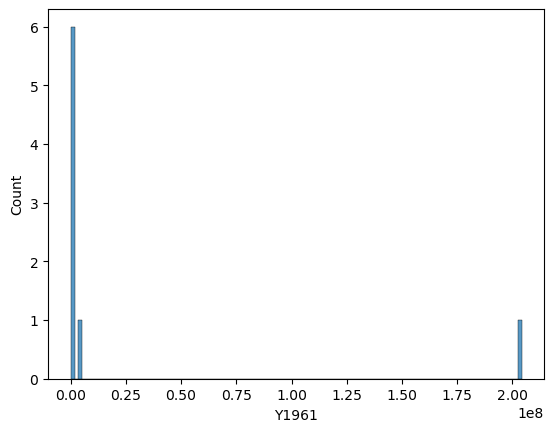

In [20]:
import seaborn as sns
sns.histplot(all_df_merged.loc[all_df_merged["Element"] == "area harvested", "Y1961"].describe())

In [21]:

import json

def convert_df_to_hierarchical_json(df,value_item, value_typology = 'CF_food_typology',value_group ='CF_group'):
    # Create the root node with 'children' for each unique food_commodity_group
    result = {"name": "Food", "children": []}
    
    # Group by the first level (food_commodity_group)
    for group_name, group_df in df.groupby('food_commodity_group'):
        cf_value_group = group_df[value_group].mean()
        group_node = {"name": group_name, "value": round(float(cf_value_group),2),"children": []}
        #group_node = {"name": group_name, "children": []}
        # Group by the second level (food_commodity_typology)
        for typology_name, typology_df in group_df.groupby('food_commodity_typology'):
            cf_value_typo = typology_df[value_typology].mean()
            typology_node = {"name": typology_name,"value": round(float(cf_value_typo),2), "children": []}
            #typology_node = {"name": typology_name, "children": []}
            # Group by the third level (food_commodity_item)
            for item_name, item_df in typology_df.groupby('food_commodity_item'):
                # If there are multiple CF_food_item values for a single item, 
                # we take the average or any other aggregation you prefer
                cf_value = item_df[value_item].mean()
                
                item_node = {"name": item_name, "value": round(float(cf_value),2)}
                #item_node = {"name": item_name}
                typology_node["children"].append(item_node)
            
            group_node["children"].append(typology_node)
        
        result["children"].append(group_node)
    
    return json.dumps(result, indent=2)

co2_json = convert_df_to_hierarchical_json(co2_and_water,'CF_food_item')
# Writing to sample.json
with open("data/data_carbon.json", "w") as outfile:
    outfile.write(co2_json)
water_json = convert_df_to_hierarchical_json(co2_and_water,'Water Footprint liters water/kg o liter of food ITEM',value_typology = 'Water Footprint cc water/g o cc of food TYPOLOGY',value_group ='WF_group')
# Writing to sample.json
with open("data/data_water.json", "w") as outfile:
    outfile.write(water_json)


In [22]:
import json
def convert_df_to_hierarchical_json_country(df):
    # Create the root node with 'children' for each unique food_commodity_group
    result = {"name": "Item", "children": []}
    
    # Group by the first level (food_commodity_group)
    for item_name, item_df in df.groupby('food_commodity_item'):
        # If there are multiple CF_food_item values for a single item, 
        # we take the average or any other aggregation you prefer
                
        item_node = {"name": item_name,  "children": []}
        #item_node = {"name": item_name}

        for country_name, country_df in item_df.groupby('Area'):            
            country_node = {"name": country_name, "children": []}
            # Group by the second level (food_commodity_typology)
            for element_name, element_df in country_df.groupby("Element"):
                element_node  = {"name": element_name, "children": []}
                filtered_df = element_df.filter(regex=r'Y\d+$')
                filtered_df = filtered_df.dropna(axis= 1)
                filtered_df.columns = filtered_df.columns.str[1:]
                for year in filtered_df.columns:
                    
                    year_node = {"name": year, "value": int(filtered_df[year].iloc[0])}
                    element_node["children"].append(year_node)
            
                country_node["children"].append(element_node)

            item_node["children"].append(country_node)    

        result["children"].append(item_node)
    
    return json.dumps(result, indent=2)

country_df = convert_df_to_hierarchical_json_country(all_df_merged)
# Writing to sample.json
with open("data/data_per_country.json", "w") as outfile:
    outfile.write(country_df)

In [23]:
list(all_df_merged.columns)

['Unnamed: 0',
 'food_commodity_group',
 'food_commodity_item',
 'CF_food_item',
 'uncertainty',
 'Suggested CF value',
 'food_commodity_typology',
 'CF_food_typology',
 'Food_commodity_sub-TYPOLOGY_x',
 'CF_food_sub_typology',
 'Water Footprint liters water/kg o liter of food ITEM',
 'Uncertainty    low  (L)  high (H)',
 'Suggested WF value',
 'Water Footprint cc water/g o cc of food TYPOLOGY',
 'Food_commodity_sub-TYPOLOGY_y',
 'Water Footprint cc water/g o cc of food sub-TYPOLOGY',
 'CF_group',
 'WF_group',
 'Area Code',
 'Area Code (M49)',
 'Area',
 'Item Code',
 'Item Code (CPC)',
 'Item',
 'Element Code',
 'Element',
 'Unit',
 'Y1961',
 'Y1961F',
 'Y1961N',
 'Y1962',
 'Y1962F',
 'Y1962N',
 'Y1963',
 'Y1963F',
 'Y1963N',
 'Y1964',
 'Y1964F',
 'Y1964N',
 'Y1965',
 'Y1965F',
 'Y1965N',
 'Y1966',
 'Y1966F',
 'Y1966N',
 'Y1967',
 'Y1967F',
 'Y1967N',
 'Y1968',
 'Y1968F',
 'Y1968N',
 'Y1969',
 'Y1969F',
 'Y1969N',
 'Y1970',
 'Y1970F',
 'Y1970N',
 'Y1971',
 'Y1971F',
 'Y1971N',
 'Y1972'

In [24]:
all_df_merged = all_df_merged.filter(regex=r'^(?!Y\d+(F|N)).*',axis=1)

In [ ]:
all_df_merged.drop(columns=["Unnamed: 0",
                            "uncertainty",
                             "Suggested CF value",
                            "Food_commodity_sub-TYPOLOGY_x",
                            'CF_food_sub_typology',
                            'Uncertainty    low  (L)  high (H)',
                            'CF_food_item',
                            'Water Footprint cc water/g o cc of food TYPOLOGY',
                            'CF_food_typology', 'CF_food_sub_typology',
                            'Water Footprint liters water/kg o liter of food ITEM',
                            'Suggested WF value', 'Food_commodity_sub-TYPOLOGY_y',
                            'Water Footprint cc water/g o cc of food sub-TYPOLOGY', 'CF_group',
                            'WF_group', 
                            'Area Code',
                            'Area Code (M49)',
                            'Item Code',
                            'Item Code (CPC)',
                            "Element Code"
                            ], inplace=True)

In [33]:
all_df_merged[all_df_merged["Item"]=="margarine"]["Element"].unique()

array(['production'], dtype=object)

In [26]:
all_df_merged.to_csv("data/merged_data.csv", index=False)
# Save the individual dataframes for further use

In [27]:
len(all_df_merged["food_commodity_item"].unique())

70

In [28]:
def df_without_common(df ,column_name):
    return df[~df[column_name].isin(list(all_df_merged["food_commodity_item"]))]

def export_to_txt_the_column(df ,column_name :str,export_name :str):
    df = df_without_common(df ,column_name).drop_duplicates(subset = column_name)
    df[column_name].to_csv(f'data/{export_name}.txt', sep=" ", index=False)


export_to_txt_the_column(df_prod ,"Item","df_prod")
#export_to_txt_the_column(df_co2 ,"food_commodity_item","df_co2")
#export_to_txt_the_column(df_water ,"food_commodity_item","df_water")

In [29]:
export_to_txt_the_column(df_prod ,"Item","df_prod")

In [30]:
def export_df(df,name_of_excel):
    df_to_export =df_without_common(df ,"food_commodity_item")
    df_to_export = df_to_export.sort_values(by= "food_commodity_item",axis=0, ascending=True)
    df_without_common(df_to_export ,"food_commodity_item").to_excel(f"{name_of_excel}.xlsx")

In [31]:
co2_and_water

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY_x,CF_food_sub_typology,Water Footprint liters water/kg o liter of food ITEM,Uncertainty low (L) high (H),Suggested WF value,Water Footprint cc water/g o cc of food TYPOLOGY,Food_commodity_sub-TYPOLOGY_y,Water Footprint cc water/g o cc of food sub-TYPOLOGY,CF_group,WF_group
0,3,processed food,chocolate or cream filled cookie,1.53300,l,ok item,biscuits,1.47,NaN,NaN,2902.0,l,ok item,1870.0,NaN,NaN,1.54,2278.92
1,4,processed food,simple cookie,1.39075,l,ok item,biscuits,1.47,NaN,NaN,1723.0,l,ok item,1870.0,NaN,NaN,1.54,2278.92
2,6,processed food,bread multicereal,0.70300,h,better typology,bread,0.98,NaN,NaN,771.0,l,better typology,1006.2,NaN,NaN,1.54,2278.92
3,7,processed food,bread plain,0.88500,l,ok item,bread,0.98,NaN,NaN,1031.0,l,ok item,1006.2,NaN,NaN,1.54,2278.92
4,8,processed food,bread whole,0.77200,l,ok item,bread,0.98,NaN,NaN,887.0,l,ok item,1006.2,NaN,NaN,1.54,2278.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN,1.54,2278.92
138,1,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN,1.54,2278.92
139,2,processed food,beer,0.69000,l,ok item,drinks,1.74,NaN,NaN,155.0,h,item matching typology,2455.5,NaN,NaN,1.54,2278.92
140,95,processed food,wine,0.66000,l,ok item,drinks,1.74,NaN,NaN,524.0,l,item matching typology,2455.5,NaN,NaN,1.54,2278.92


In [80]:
all_df_merged

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY_x,CF_food_sub_typology,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,1778.25,i,NaN,4396.69,i,NaN,NaN,NaN,NaN
2,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,15724.60,i,NaN,16609.97,i,NaN,NaN,NaN,NaN
3,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,96.60,a,NaN,138.80,a,NaN,NaN,NaN,NaN
4,56,processed food,margarine,1.39,l,item matching typology,plant-based dairy products,0.93,NaN,NaN,...,NaN,105839.58,i,NaN,99382.05,i,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24335,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,7787.29,e,NaN,7279.47,e,NaN,NaN,NaN,NaN
24336,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,378076.85,e,NaN,378175.21,e,NaN,NaN,NaN,NaN
24337,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,16228.00,e,NaN,14214.00,e,NaN,NaN,NaN,NaN
24338,96,processed food,wine,0.66,h,better typology,drinks,1.74,NaN,NaN,...,NaN,27202.37,e,NaN,26719.03,e,NaN,NaN,NaN,NaN


In [81]:
.to_excel(f"{name_of_excel}.xlsx")

SyntaxError: invalid syntax (970813728.py, line 1)

In [ ]:
# Your original inner merge
outer_merge =  df_co2.merge(df_water, on = ["food_commodity_item","food_commodity_group","food_commodity_typology"], how='outer')
outer_merge = outer_merge.merge(df_prod, left_on = "food_commodity_item",right_on= "Item",  how='outer')
outer_merge

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY_x,CF_food_sub_typology,...,Y2020N,Y2021,Y2021F,Y2021N,Y2022,Y2022F,Y2022N,Y2023,Y2023F,Y2023N
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,19573.00,i,NaN,19802.00,i,NaN,19567.00,e,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,762.30,e,NaN,747.70,e,NaN,760.40,e,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,14920.43,e,NaN,14806.29,e,NaN,14878.10,e,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7975.00,e,NaN,7932.00,e,NaN,7959.00,e,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,453.10,e,NaN,455.90,e,NaN,453.40,e,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79254,NaN,crops,NaN,NaN,NaN,NaN,seeds,NaN,NaN,NaN,...,NaN,203488.92,e,NaN,203651.57,e,NaN,203544.52,e,NaN
79255,NaN,crops,NaN,NaN,NaN,NaN,seeds,NaN,NaN,NaN,...,NaN,1458337.13,e,NaN,1388235.88,e,NaN,NaN,NaN,NaN
79256,NaN,crops,NaN,NaN,NaN,NaN,seeds,NaN,NaN,NaN,...,NaN,30309682.00,e,NaN,30292605.00,e,NaN,31289718.00,e,NaN
79257,NaN,crops,NaN,NaN,NaN,NaN,seeds,NaN,NaN,NaN,...,NaN,747.00,e,NaN,783.60,e,NaN,774.70,e,NaN


In [ ]:
export_df(df_common,"df_common")

In [ ]:
export_df(df_co2,"df_co2")
export_df(df_water,"df_water")

In [ ]:
common = pd.read_csv("food-commodity-mapping-csv(1).txt")

FileNotFoundError: [Errno 2] No such file or directory: 'food-commodity-mapping-csv(1).txt'

In [ ]:
common = common[~common["prod.txt"].str.contains("-")]

NameError: name 'common' is not defined

In [ ]:
common.to_excel("data/commmon.xlsx")

NameError: name 'common' is not defined

In [ ]:
from_co2_to_common = dict(zip(common['co2_item.txt'], common['Shortest Name']))
df_co2["food_commodity_item"] = df_co2["food_commodity_item"].replace(from_co2_to_common)
df_co2

,Unnamed: 0,food_commodity_group,food_commodity_item,CF_food_item,uncertainty,Suggested CF value,food_commodity_typology,CF_food_typology,Food_commodity_sub-TYPOLOGY,CF_food_sub_typology
0,0,AGRICULTURAL PROCESSED,BEER IN CAN,0.693000,L,OK item,BEER,0.69,NaN,NaN
1,1,AGRICULTURAL PROCESSED,BEER IN GLASS,0.960500,L,OK item,BEER,0.69,NaN,NaN
2,2,AGRICULTURAL PROCESSED,BEER MODULAR CAN,0.530600,L,OK item,BEER,0.69,NaN,NaN
3,3,AGRICULTURAL PROCESSED,CHOCOLATE OR CREAM FILLED COOKIES,1.533000,L,OK item,BISCUITS,1.47,NaN,NaN
4,4,AGRICULTURAL PROCESSED,SIMPLE COOKIES,1.390750,L,OK item,BISCUITS,1.47,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
319,319,FISHING,OCTOPUS,5.800000,H,better typol. or subtypol.,SHELLFISH,5.67,CEPHALOPOD (SUB-TYP),5.80
320,320,FISHING,SQUID,6.910000,H,better typol. or subtypol.,SHELLFISH,5.67,CEPHALOPOD (SUB-TYP),5.80
321,321,FISHING,PRAWNS/SHRIMPS,7.040000,L,OK item,SHELLFISH,5.67,CRUSTACEAN (SUB-TYP) (Prawns/Shrimps),7.04
322,322,FISHING,OCTOPUS (F),7.878611,H,better typology,SHELLFISH FROZEN,11.47,NaN,NaN


In [ ]:
from_prod_to_common = dict(zip(common['prod.txt'], common['Shortest Name']))
df_prod["food_commodity_item"] = df_prod["food_commodity_item"].replace(from_co2_to_common)

KeyError: 'food_commodity_item'

In [ ]:
#Question quand dans un des df c'est 2 sous catégorie ou prend la moyenne puis on développe après?